# VGGFace 2 and Lime Full Pipeline

We need to do five things:
1. Crop faces with MTCNN
2. Extract features with VGGFace2
3. Run Classifier
4. Fit all in one pipeline
5. Run Lime

In [1]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Crop Face

In [34]:
from crop_face import crop_faces, convert_face_tensor_to_numpy_array

face = crop_faces("./sample_images/trump.jpg", keep_all=False)

In [35]:
face.shape

torch.Size([3, 160, 160])

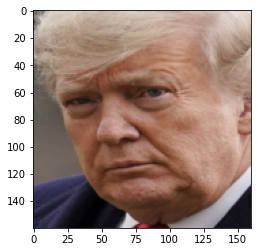

In [36]:
plt.imshow(face.permute(1, 2, 0).int().numpy())

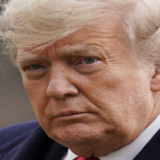

In [37]:
image = Image.fromarray(convert_face_tensor_to_numpy_array(face))
display(image)

In [38]:
image.save('./sample_images/trump.jpg')

## Load VGGFace2

In [9]:
from saved_model.prepare_resnet50 import prepare_resnet_model

resnet_model = prepare_resnet_model("./saved_model/resnet50_ft_weight.pkl")

## Load Pretrained Binary Classifier Neural Network

In [10]:
from saved_model.binary_classifier import load_pretrained_classifier

binary_classifier = load_pretrained_classifier('./saved_model/weights-2.pth')

## Putting it all together

In [11]:
mean_rgb = (131.0912, 103.8827, 91.4953)

def load_data(path='', shape=None):
    short_size = 224.0
    crop_size = shape
    img = Image.open(path)
    im_shape = np.array(img.size)    # in the format of (width, height, *)
    img = img.convert('RGB')

    ratio = float(short_size) / np.min(im_shape)
    img = img.resize(size=(int(np.ceil(im_shape[0] * ratio)),   # width
                           int(np.ceil(im_shape[1] * ratio))),  # height
                     resample=Image.BILINEAR)

    x = np.array(img)  # image has been transposed into (height, width)
    newshape = x.shape[:2]
    h_start = (newshape[0] - crop_size[0])//2
    w_start = (newshape[1] - crop_size[1])//2
    x = x[h_start:h_start+crop_size[0], w_start:w_start+crop_size[1]]
    x = x - mean_rgb
    return x

In [46]:
img = load_data('./sample_images/trump.jpg', shape=(224,224,3))
img_batch = np.expand_dims(img, 0)
img_batch.shape

(1, 224, 224, 3)

In [47]:
img_tensor = torch.Tensor(img_batch.transpose(0, 3, 1, 2))
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [48]:
def full_pipeline(x):
    x = torch.Tensor(x.transpose(0, 3, 1, 2))  # 1x3x224x224
    x = x.to(device)
    x = resnet_model(x)
    x = torch.sigmoid(binary_classifier(x))
    return x.detach().cpu().numpy()

In [42]:
label_dict = {0: "liberal", 1: "conservative"}

def predict_face(face_path=None):
    img = load_data(face_path, shape=(224,224,3))
    img_arr = np.expand_dims(img, 0) # 1x224x224x3
    prediction = full_pipeline(img_arr).squeeze(0)
    pred_int = np.rint(prediction) # 0 or 1
    label = [label_dict[i] for i in pred_int]
    confidence = 1 - prediction if pred_int == 0 else prediction
    
    return prediction, label, confidence

In [45]:
prediction, label, confidence = predict_face('./sample_images/trump.jpg')
prediction, label, confidence

(array([0.35497424], dtype=float32),
 ['liberal'],
 array([0.64502573], dtype=float32))

# Lime

In [28]:
from lime import lime_image

In [54]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, full_pipeline, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [55]:
from skimage.segmentation import mark_boundaries

In [56]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)

In [57]:
img_boundry = mark_boundaries(temp/255.0, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


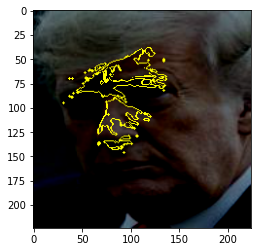

In [58]:
plt.imshow(img_boundry)